In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.14.0'

In [3]:
import keras

In [4]:
keras.__version__

'2.14.0'

In [5]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import Model
from keras.layers import Dense,Input,Dropout
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize']=10,6
RANDOM_SEED=42
LABELS=['Normal','Fraud']

In [6]:
df=pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
df.shape

(284807, 31)

In [10]:
df.isnull().values.any()

False

In [11]:
df.isna().sum().sum()

0

Text(0, 0.5, 'Frequency')

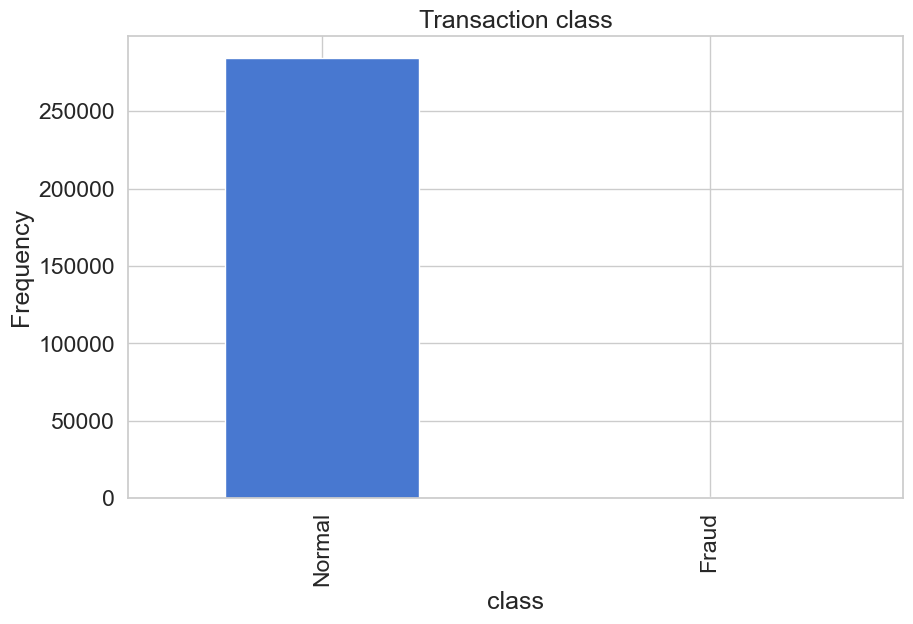

In [12]:
count_classes=pd.value_counts(df['Class'],sort=True)
count_classes.plot(kind='bar')
plt.title('Transaction class')
plt.xticks(range(2),LABELS)
plt.xlabel('class')
plt.ylabel('Frequency')

<Axes: ylabel='count'>

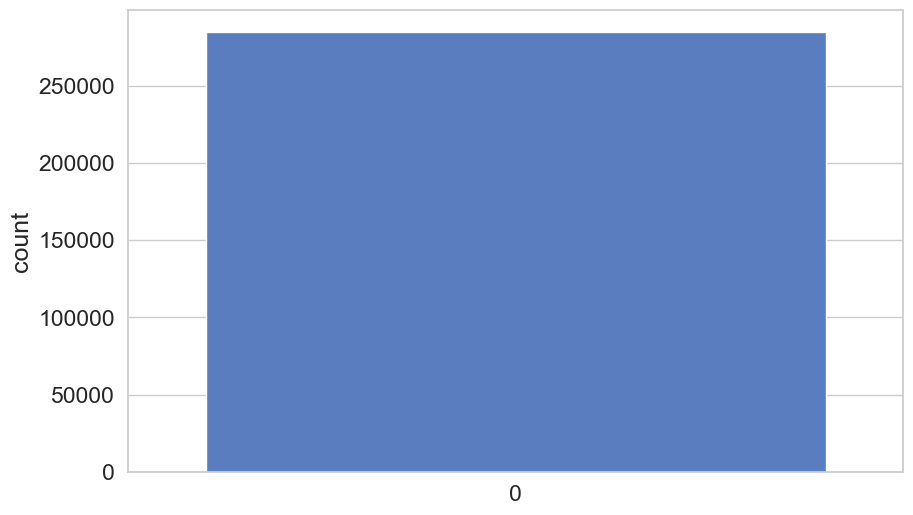

In [13]:
sns.countplot(df['Class'])

In [14]:
frauds=df[df.Class==1]
normal=df[df.Class==0]

In [15]:
frauds.shape

(492, 31)

In [16]:
normal.shape

(284315, 31)

In [17]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [18]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

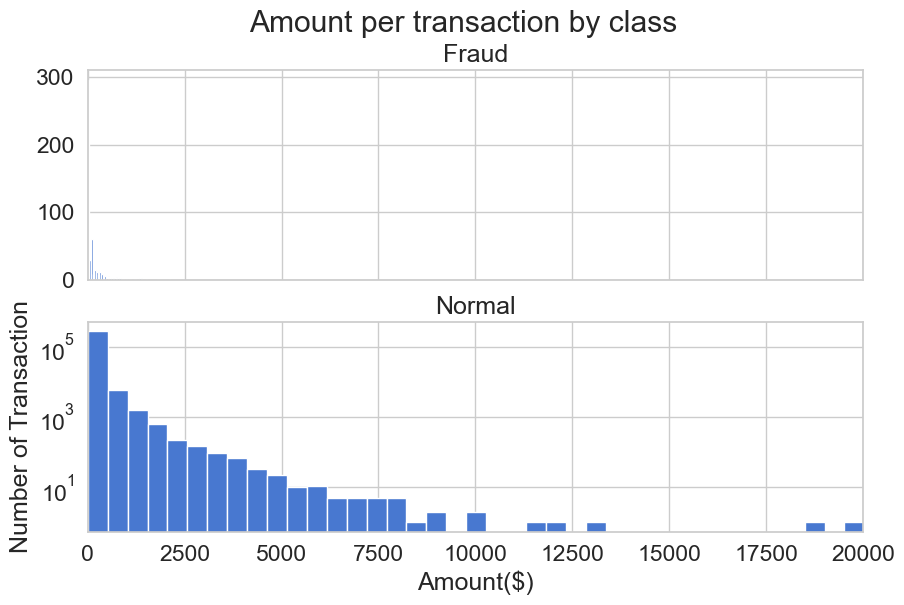

In [19]:
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
f.suptitle('Amount per transaction by class')
bins=50
ax1.hist(frauds.Amount,bins=bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount,bins=bins)
ax2.set_title('Normal')
plt.xlabel('Amount($)')
plt.ylabel('Number of Transaction')
plt.xlim((0,20000))
plt.yscale('log')
plt.show()

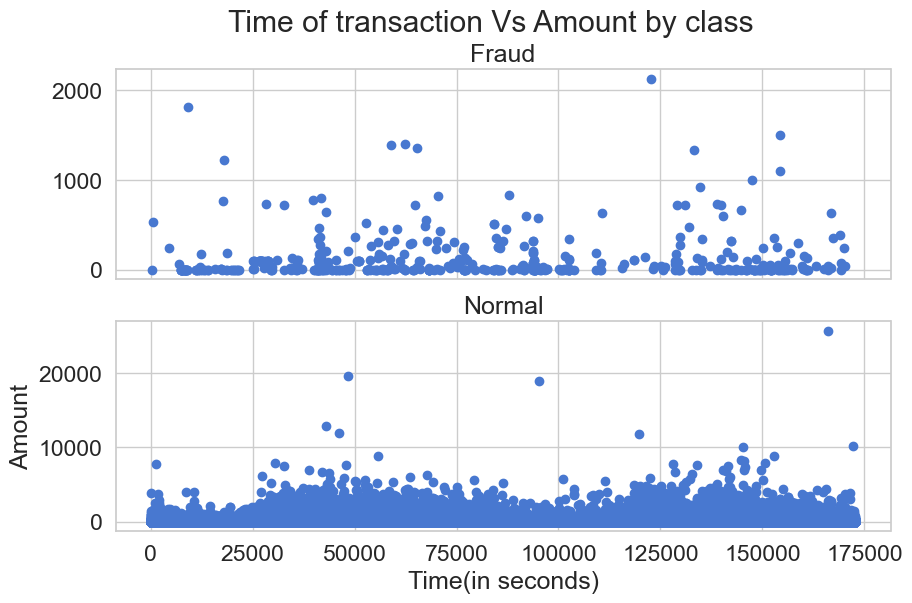

In [20]:
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
f.suptitle('Time of transaction Vs Amount by class')
ax1.scatter(frauds.Time,frauds.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time,normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time(in seconds)')
plt.ylabel('Amount')
plt.show()

In [21]:
from sklearn.preprocessing import StandardScaler
data=df.drop(['Time'],axis=1)
data['Amount']=StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

In [22]:
data['Amount'][0]

0.24496426337017338

In [23]:
xtrain,xtest=train_test_split(data,test_size=0.2,random_state=RANDOM_SEED)
xtrain=xtrain[xtrain.Class==0]
xtrain=xtrain.drop(['Class'],axis=1)
print(xtrain.shape)
print()
#print(xtrain.head(2))

(227451, 29)



In [24]:
ytest=xtest['Class']
xtest=xtest.drop(['Class'],axis=1)
xtrain=xtrain.values
xtest=xtest.values

In [25]:
print(xtrain.shape)
print()
print(xtest.shape)

(227451, 29)

(56962, 29)


In [26]:
input_dim=xtrain.shape[1]
encoding_dim=14

In [27]:
input_layer=Input(shape=(input_dim,))
encoder=Dense(encoding_dim,activation='tanh',
 activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder=Dense(int(encoding_dim/2),activation='relu')(encoder)
decoder=Dense(int(encoding_dim/2),activation='tanh')(encoder)
decoder=Dense(input_dim,activation='relu')(decoder)
autoencoder=Model(inputs=input_layer,outputs=decoder)

In [28]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 14)                420       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 7)                 56        
                                                                 
 dense_3 (Dense)             (None, 29)                232       
                                                                 
Total params: 813 (3.18 KB)
Trainable params: 813 (3.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
469/469 [==============================] - 198s 410ms/step - loss: 0.1568 - val_loss: 0.1123
Epoch 2/10
469/469 [==============================] - 185s 394ms/step - loss: 0.1092 - val_loss: 0.1063
Epoch 3/10
469/469 [==============================] - 182s 389ms/step - loss: 0.1041 - val_loss: 0.1018
Epoch 4/10
469/469 [==============================] - 201s 428ms/step - loss: 0.1015 - val_loss: 0.0996
Epoch 5/10
469/469 [==============================] - 185s 394ms/step - loss: 0.0999 - val_loss: 0.0985
Epoch 6/10
469/469 [==============================] - 205s 438ms/step - loss: 0.0988 - val_loss: 0.0975
Epoch 7/10
469/469 [==============================] - 187s 399ms/step - loss: 0.0978 - val_loss: 0.0970
Epoch 8/10
469/469 [==============================] - 205s 438ms/step - loss: 0.0971 - val_loss: 0.0961
Epoch 9/10
469/469 [==============================] - 188s 400ms/step - loss: 0.0965 - val_loss: 0.0962
Epoch 10/10
313/313 [==============================] - 10s 29ms/

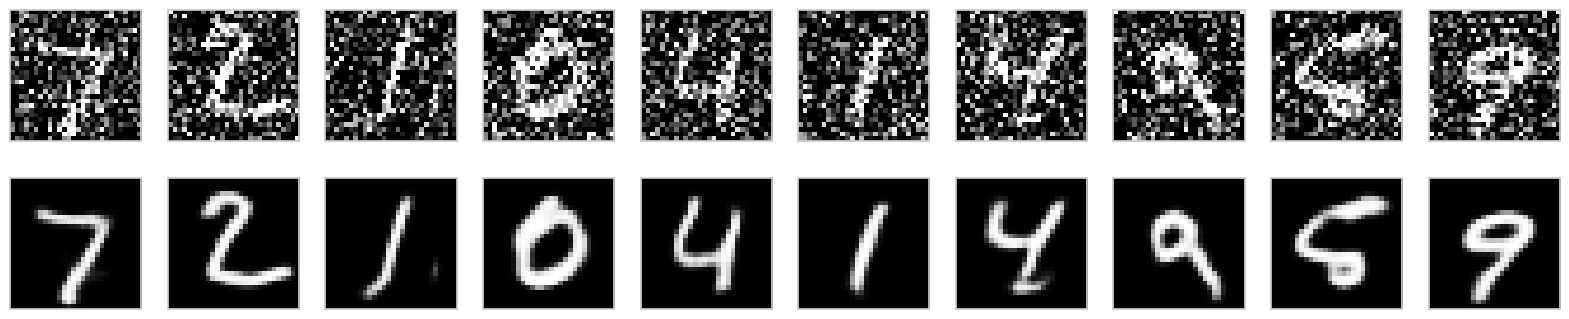

In [29]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import TensorBoard

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add random noise to the images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip values to be in the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Reshape the images to (28, 28, 1) and add a channel dimension
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
x_train_noisy = np.reshape(x_train_noisy, (len(x_train_noisy), 28, 28, 1))
x_test_noisy = np.reshape(x_test_noisy, (len(x_test_noisy), 28, 28, 1))

# Define the autoencoder model
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

# Denoise some images from the test set
decoded_imgs = autoencoder.predict(x_test_noisy)

# Plot the results
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()